# Import the result

In [224]:
import pandas as pd
import numpy as np
import csv
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [225]:
# Import all the results
# Default value
def_value_result = pd.read_csv("def_value_result.csv")
# Tune One - Random Forest
rf_n_estimators = pd.read_csv("rf_n_estimators.csv")
rf_bootstrap = pd.read_csv("rf_bootstrap.csv")
rf_max_samples = pd.read_csv("rf_max_samples.csv")
rf_max_features = pd.read_csv("rf_max_features.csv")
rf_min_samples_leaf = pd.read_csv("rf_min_samples_leaf.csv")
# Tune One - XGBoost
xgb_num_boost_round = pd.read_csv("xgb_num_boost_round.csv")
xgb_lambda = pd.read_csv("xgb_lambda.csv")
xgb_alpha = pd.read_csv("xgb_alpha.csv")
xgb_eta = pd.read_csv("xgb_eta.csv")
xgb_subsample = pd.read_csv("xgb_subsample.csv")
xgb_max_depth = pd.read_csv("xgb_max_depth.csv")
xgb_min_child_weight = pd.read_csv("xgb_min_child_weight.csv")
xgb_colsample_bytree = pd.read_csv("xgb_colsample_bytree.csv")
xgb_colsample_bylevel = pd.read_csv("xgb_colsample_bylevel.csv")
# Grid Search
rf_grid_result = pd.read_csv("rf_grid_result.csv")
xgb_grid_result = pd.read_csv("xgb_grid_result.csv")
# Random Search
rf_rs_result = pd.read_csv("rf_rs_result.csv")
xgb_rs_result = pd.read_csv("xgb_rs_result.csv")
# Bayesian Optimization
rf_bo_result = pd.read_csv("rf_bo_result.csv")
xgb_bo_result = pd.read_csv("xgb_bo_result.csv")

In [226]:
# Import all the datasets
df_list = []
dmat_list = []
num_datasets = 27
for i in range(num_datasets):
    df = pd.read_csv("df{}.csv".format(i)) 
    df_list.append(df)
    dmat = xgb.DMatrix(df.iloc[:,1:df.shape[1]], label=df.iloc[:,0])
    dmat_list.append(dmat)

# Default values

In [104]:
# Random Forest
# Define the parameter search space
dval = {
    'n_estimators': 100, # "num.trees": 500 / "n_estimators": 100
    'criterion': 'mse',
    'bootstrap': True, # replace
    'max_samples': None, # sample.fraction
    'max_features': 'sqrt', ### "mtry": "sqrt" / "max_features": "auto" ###
    'min_samples_leaf': 1, # "min.node.size" default: 5 / "min_samples_leaf": 1
}
# Fit the model to each dataset
def_result = pd.DataFrame(columns=['rf_rmse'])
mlist = []
mod = RandomForestRegressor(**dval)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, 
                           scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
def_result['rf_rmse'] = mlist

In [123]:
# XGBoost
# Define the parameter search space
dval = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(dval, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
def_result["xgb_rmse"] = mlist

In [232]:
print("Mean of rmse: \n",def_result.mean(axis=0),"\n")
print("Standard deviation of rmse: \n",def_result.std(axis=0))

Mean of rmse: 
 rf_rmse     7.188438
xgb_rmse    6.960066
dtype: float64 

Standard deviation of rmse: 
 rf_rmse     2.823852
xgb_rmse    3.653274
dtype: float64


In [233]:
print("RMSE of default values: {}".format(def_result.mean(axis=0)[0]), "\n")
print("RMSE of default values: {}".format(def_result.mean(axis=0)[1]))

RMSE of default values: 7.188437947238364 

RMSE of default values: 6.960065807407409


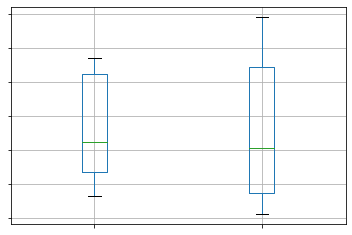

In [178]:
dv_plot = def_result.boxplot()
dv_plot

# Tunability of single hyperparameter

## 1. Random Forest

In [71]:
# n_estimators
target = rf_n_estimators
# Best hyperparameter
best = target["value"].idxmin()
param = {'n_estimators': target.iloc[best,:][5],
         'criterion': 'mse',
         'bootstrap': True,
         'max_samples': None,
         'max_features': 'sqrt',
         'min_samples_leaf': 1}
# Fit the model to each datsets
rf_tune_one = pd.DataFrame(columns=['n_estimators'])
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
rf_tune_one['n_estimators'] = mlist

In [72]:
# bootstrap
target = rf_bootstrap
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {'n_estimators': 100,
         'criterion': 'mse',
         'bootstrap': val,
         'max_samples': None,
         'max_features': 'sqrt',
         'min_samples_leaf': 1}
# Fit the model to each datsets
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
rf_tune_one['bootstrap'] = mlist

In [75]:
# max_samples
target = rf_max_samples
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {'n_estimators': 100,
         'criterion': 'mse',
         'bootstrap': True,
         'max_samples': val,
         'max_features': 'sqrt',
         'min_samples_leaf': 1}
# Fit the model to each datsets
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
rf_tune_one['max_samples'] = mlist

In [76]:
# max_features
target = rf_max_features
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {'n_estimators': 100,
         'criterion': 'mse',
         'bootstrap': True,
         'max_samples': None,
         'max_features': val,
         'min_samples_leaf': 1}
# Fit the model to each datsets
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
rf_tune_one['max_features'] = mlist

In [117]:
# min_samples_leaf
target = rf_min_samples_leaf
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {'n_estimators': 100,
         'criterion': 'mse',
         'bootstrap': True,
         'max_samples': None,
         'max_features': 'sqrt',
         'min_samples_leaf': int(val)}
# Fit the model to each datsets
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
rf_tune_one['min_samples_leaf'] = mlist

In [119]:
rf_tune_one.insert(0, column='default', value=def_result.iloc[:,0])
rf_tune_one

,default,n_estimators,bootstrap,max_samples,max_features,min_samples_leaf
0,4.164081,4.163676,4.193671,4.182185,3.774048,4.148849
1,6.486712,6.406425,6.651739,6.532629,6.524477,6.435129
2,11.068842,11.079978,11.096068,11.096376,10.901847,10.894888
3,4.779594,4.723038,4.704867,4.764991,4.468592,4.728093
4,7.264643,7.150328,7.198562,7.099187,7.172794,7.035567
5,11.419200,11.548048,11.736723,11.656355,11.733810,11.392738
6,4.745277,4.710559,4.697017,4.694210,3.735217,4.654887
7,6.116832,6.114048,6.058755,6.104159,5.983225,6.030611
8,9.634861,9.595652,9.762372,9.787630,9.426359,9.716546
9,3.502886,3.537832,3.346443,3.534064,2.525076,3.526538


In [223]:
print("Mean of rmse:\n", rf_tune_one.mean(), "\n")
print("Std of rmse: \n", rf_tune_one.std())
rf_tune_one.to_csv("rf_tune_one.csv", index=False)

Mean of rmse:
 default             7.188438
n_estimators        7.158107
bootstrap           7.133449
max_samples         7.186462
max_features        6.597200
min_samples_leaf    7.161984
dtype: float64 

Std of rmse: 
 default             2.823852
n_estimators        2.831001
bootstrap           2.879002
max_samples         2.839927
max_features        3.236536
min_samples_leaf    2.830730
dtype: float64


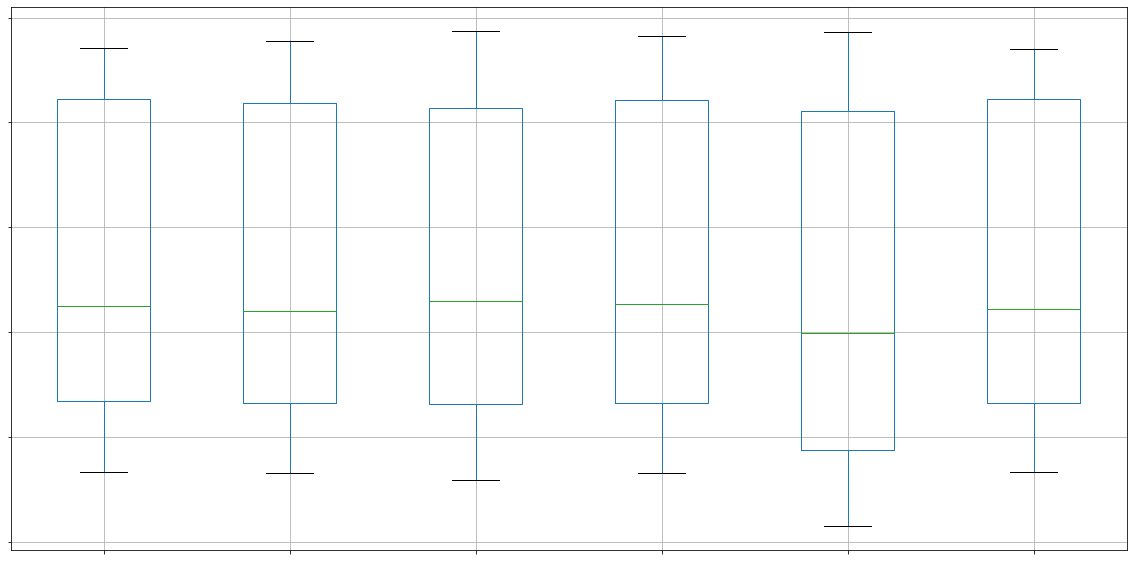

In [154]:
rf_tune_one.boxplot(figsize=(20,10))

# 2. XGBoost

In [191]:
xgb_tune_one = pd.DataFrame(data=def_result.iloc[:,1].values.ravel(), columns=['default'])
# lambda
target = xgb_lambda
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": val,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["lambda"] = mlist

In [194]:
# alpha
target = xgb_alpha
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": val,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["alpha"] = mlist

In [196]:
# eta
target = xgb_eta
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": val,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["eta"] = mlist

In [197]:
# subsample
target = xgb_subsample
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": val,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["subsample"] = mlist

In [199]:
# max_depth
target = xgb_max_depth
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": int(val),
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["max_depth"] = mlist

In [201]:
# min_child_weight
target = xgb_min_child_weight
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": int(val),
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["min_child_weight"] = mlist

In [203]:
# colsample_bytree
target = xgb_colsample_bytree
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": val,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["colsample_bytree"] = mlist

In [204]:
# colsample_bylevel
target = xgb_colsample_bylevel
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": val
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one["colsample_bylevel"] = mlist

In [207]:
# num_boost_round
target = xgb_num_boost_round
# Best hyperparameter
best = target["value"].idxmin()
val = target.iloc[best,:][5]
param = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = val
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
xgb_tune_one.insert(1, column="num_boost_round",value=mlist)

In [211]:
xgb_tune_one

,default,num_boost_round,lambda,alpha,eta,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel
0,3.485980,3.442551,3.673997,3.415693,3.485980,3.485980,3.199025,4.757930,3.485980,3.705964
1,6.950154,6.907205,7.109430,6.903711,6.950154,6.950154,6.681826,6.424638,6.950154,6.826435
2,11.921989,11.954127,12.064674,11.709138,11.921989,11.921989,11.811400,10.667291,11.921989,11.566980
3,4.610960,4.577426,4.690707,4.639455,4.610960,4.610960,3.965434,4.912964,4.610960,4.467350
4,7.602259,7.511600,7.279410,7.607000,7.602259,7.602259,8.025462,7.297839,7.602259,7.411149
5,13.823878,14.021954,12.762547,13.683796,13.823878,13.823878,12.907924,11.603148,13.823878,12.463672
6,3.441053,3.431942,3.739486,3.454440,3.441053,3.441053,3.225302,4.863938,3.441053,3.675041
7,5.706423,5.701820,6.045979,5.632324,5.706423,5.706423,5.730378,6.241171,5.706423,5.897558
8,11.041093,11.125039,10.180957,10.750389,11.041093,11.041093,10.478511,9.779190,11.041093,9.981541
9,2.613650,2.447711,2.623967,2.633333,2.613650,2.613650,2.582229,2.379361,2.613650,2.865350


In [222]:
print("Mean of rmse:\n", xgb_tune_one.mean(), "\n")
print("Std of rmse: \n", xgb_tune_one.std())
xgb_tune_one.to_csv("xgb_tune_one.csv", index=False)

Mean of rmse:
 default              6.960066
num_boost_round      6.935800
lambda               6.946966
alpha                6.931164
eta                  6.960066
subsample            6.960066
max_depth            6.649057
min_child_weight     6.630256
colsample_bytree     6.960066
colsample_bylevel    6.931296
dtype: float64 

Std of rmse: 
 default              3.653274
num_boost_round      3.731838
lambda               3.502335
alpha                3.627439
eta                  3.653274
subsample            3.653274
max_depth            3.485243
min_child_weight     3.308986
colsample_bytree     3.653274
colsample_bylevel    3.419731
dtype: float64


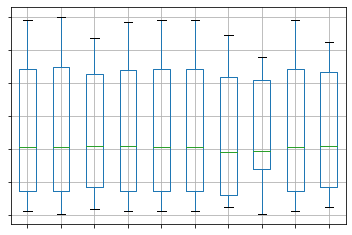

In [214]:
xgb_tune_one.boxplot()

# Result of the three methods

In [227]:
all_result = pd.DataFrame(columns=['rf_grid'])

## Random Forest

In [229]:
val = []
idx = rf_grid_result["value"].idxmin()
best = rf_grid_result.iloc[idx,:]
for i in range(5, 10):
    val.append(best[i])
val[3] = int(val[3])
val
num_datasets

27

In [230]:
# Define the parameter search space
param = {
    'n_estimators': 1000, # "num.trees": 500 / "n_estimators": 100
    'criterion': 'mse',
    'bootstrap': True, # replace
    'max_samples': None, # sample.fraction
    'max_features': "auto", ### "mtry": "sqrt" / "max_features": "auto" ###
    'min_samples_leaf': 1 # "min.node.size" default: 5 / "min_samples_leaf": 1
}
# Fit the model to each dataset
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, 
                           scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
all_result['rf_grid'] = mlist

KeyboardInterrupt: 

In [ ]:
all_result

In [ ]:
# random
val = []
idx = rf_rs_result["value"].idxmin()
best = rf_rs_result.iloc[idx,:]
for i in range(5, 10):
    val.append(best[i])
val[3] = int(val[3])
# Define the parameter search space
param = {
    'n_estimators': val[4], # "num.trees": 500 / "n_estimators": 100
    'criterion': 'mse',
    'bootstrap': val[0], # replace
    'max_samples': val[2], # sample.fraction
    'max_features': val[1], ### "mtry": "sqrt" / "max_features": "auto" ###
    'min_samples_leaf': val[3] # "min.node.size" default: 5 / "min_samples_leaf": 1
}
# Fit the model to each dataset
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, 
                           scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
all_result['rf_random'] = mlist

In [ ]:
# bayesian
val = []
idx = rf_bo_result["value"].idxmin()
best = rf_bo_result.iloc[idx,:]
for i in range(5, 10):
    val.append(best[i])
val[3] = int(val[3])
# Define the parameter search space
param = {
    'n_estimators': val[4], # "num.trees": 500 / "n_estimators": 100
    'criterion': 'mse',
    'bootstrap': val[0], # replace
    'max_samples': val[2], # sample.fraction
    'max_features': val[1], ### "mtry": "sqrt" / "max_features": "auto" ###
    'min_samples_leaf': val[3] # "min.node.size" default: 5 / "min_samples_leaf": 1
}
# Fit the model to each dataset
mlist = []
mod = RandomForestRegressor(**param)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, 
                           scoring="neg_root_mean_squared_error", cv=5)
    mlist.append(abs(rmse).mean())
all_result['rf_bayesian'] = mlist

In [ ]:
# XGBoost
# Define the parameter search space
dval = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(dval, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
def_result["xgb_rmse"] = mlist